In [1]:
%run Latex_macros.ipynb 


<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
         
    
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import recipe_helper
%aimport recipe_helper
rh = recipe_helper.Recipe_Helper()

# Transformation pipelines

A transformation pipeline is a
 a sequence (sometimes called a *pipeline*) of independent transformations $T_1, T_2, \ldots, T_t$

$$
\begin{array}[lll] \\
\tilde{\x}_{(1)} = T_1( \x ) \\
\tilde{\x}_{(2)} = T_1( \tilde{\x}_{(1)} ) \\
\vdots \\
\tilde{\x}_{(\ll+1)} = T_1( \tilde{\x}_{(\ll)} ) \\
\end{array}
$$

The final transformed $\tilde{\x}$ can be implemented as a function $T$ that is the composition
of each transformation function
$$
\tilde{x} = T(\x) = T_t( \; T_{t-1}( \ldots T_1(\x) \ldots ) \; )
$$



The composed transformation $T$ needs to be
- fit to training examples
- applied to out of sample examples

Having an easy way to create the composed transformation is important
- To ensure consistency
- To allow it to be applied during Cross Validation, when one fold is held out

You can
- create your own class and methods for a transformation
    - with a "fit" method to fit during training
    - with a "transform" method to apply
        - during training
        - during test


        
Alternatively, you can take advantage of `sklearn`'s built-in "pipelines"

We will briefly review what `sklearn` has to offer.

# Pipelines in sklearn

`sklearn` has created a generic architecture called `Pipeline` to simplify this for you.

This module is **not meant to be a tutorial**, only to highlight a very convenient tool in `sklearn`.

[Here](https://scikit-learn.org/stable/modules/compose.html) is a link to `sklearn`'s manual.

Let's illustrate with a two-step sequence of transformations on numeric features
- Missing data imputation
    - If feature $j$ is missing for example $i$ ($\x^\ip_j$ not defined)
    - Replace it with the median (over all $m$ examples) of $\x_j$
- Add a second order polynomial feature to each example

Here is some illustrative code

- Each transformation has a `fit` and `transform` method, just like a model (e.g., `LinearRegression`)
- The `Pipeline` is a composed transformation
    - Each element of the Pipeline is a tuple
        - name of the transformation (for your convenience in referencing it)
        - the transformer
    - The Pipeline object also respond to `fit` and transform
        - `fit` on the `num_pipe` applies `fit` to each of it's elements, in sequence

Pipelines in `sklearn`
- Make it easy to combine independent transformations
- Fit the Pipeline on *training* examples (invoke `fit` of the pipeline, passing in training examples)
- Apply the Pipeline *consistently* to any example, in or out of sample (invoke `transform`)

Observe that transformers and models both respond to the `fit` and `transform` methods.

This means that you can include a model as the final element of a Pipeline !


You can fit the transformations *and* the model in one step
- `full_pipe.fit(X, y`)

In addition to being a concise and convenient notation, pipelines with models as final elements
- Can be used in Cross Validation to avoid "cheating"
- The cross validation code passes in *only* the folds that are the training examples

# Example: Pipeline with model as final element

In [4]:
# I will give you the data via a function (so I can easily alter the data in subsequent examples)
v1, a1 = 1, .005
lin = recipe_helper.Recipe_Helper(v = v1, a = a1)

X_lin, y_lin = lin.gen_data(num=50)

v2, a2 = v1, a1*2
curv = recipe_helper.Recipe_Helper(v = v2, a = a2)
X_curve, y_curve = curv.gen_data(num=50)

X_train, X_test, y_train, y_test = rh.split(X_curve,y_curve)


In [5]:
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing as pre_proc

# Create the Pipeline
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(pre_proc.PolynomialFeatures(2),
                           linear_model.LinearRegression())

# Fit the model, running the data transformation first
_= poly_model.fit(X_train.reshape(-1,1), y_train)

A pipeline successively applies tranformations, with the result of transformation $(i-1)$ fed as input to transformation $i$.

Let's look "inside" the pipeline at the stages, and apply them manually.

In [6]:
# Examine the "stages" of the pipeline
print("Input shape: {shp}".format(shp=X_test.reshape(-1,1).shape)  )

# First stage: Create First and Second Order polynomial features
(label_0, model_0) = poly_model.steps[0]
transf_0 = model_0.transform(X_test.reshape(-1,1))
print("{lab:s} returns shape: {shp}".format(lab=label_0, shp=transf_0.shape) )

# Second stage: Linear Regression
(label_1, model_1) = poly_model.steps[1]
transf_1 = model_1.predict( transf_0 )
print("{lab:s} returns shape: {shp}".format(lab=label_1, shp=transf_1.shape) )


Input shape: (10, 1)
polynomialfeatures returns shape: (10, 3)
linearregression returns shape: (10, 1)


In [7]:
# Prediction based on test set
y_pred = poly_model.predict(X_test.reshape(-1,1))

# In and out of sample scores
print("Score (train): ", poly_model.score(X_train.reshape(-1,1), y_train))
print("Score (test): ",  poly_model.score(X_test.reshape(-1,1),  y_test))

Score (train):  1.0
Score (test):  1.0


In [8]:
# Plot the results
# Create a figure
fig, axs = plt.subplots(1,2, figsize=(12,6))

_= axs[0].scatter(X_train,y_train)

xfit = np.linspace( X_train[:,0].min(), X_train[:,0].max()).reshape(-1,1)
yfit = poly_model.predict(xfit)
_= axs[0].plot(xfit, yfit);
_= axs[0].set_title("Train")

_ = axs[1].scatter(X_test, y_test, color="blue")
_ = axs[1].scatter(X_test, y_pred, color="red")

_= axs[1].plot(xfit, yfit)
_= axs[1].set_title("Test")


print("R-squared score (test): {:.2f}".format(r2_score(y_test, y_pred)) )

# Hide the figure for now, will show it in the next slide
plt.close(fig)

R-squared score (test): 1.00


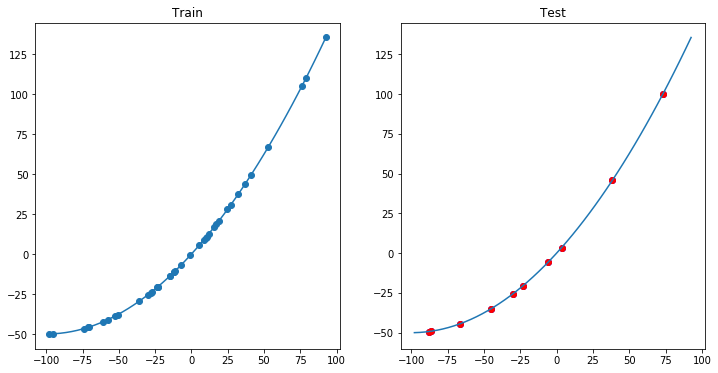

In [9]:
fig

[Here's](external/PythonDataScienceHandbook/notebooks/05.04-Feature-Engineering.ipynb#Feature-Pipelines) a slightly longer pipeline from VanderPlas.


- `Imputer` to deal with misssing values
- `PolynomialFeatures(degree=2)`
- `LinearRegression()`

# Nested Pipelines

A Pipeline responds to the same methods (`fit`, `transform`) as its elements.

This means that a Pipeline can also be used as a *nested* element of an outer Pipeline.

This is very convenient: we will illustrate this in our detailed example for Classification.

# Advanced Pipelines

An issue with Pipelines is that
each transformation is applied to *all* the features in an example.

But some transformations need to be applied to *selected* features
- Can't apply numeric transformations to non-numeric data, and vice-versa
- May want to apply a particular transformation to only a subset of features

`sklearn` facilitates this by
- Allowing you to create "filters" that restrict features to a subset
- Applying one pipeline per subset
- Creating a union of transformed features at the end


## `FeatureUnion`

`sklearn` allows you to create complex Pipelines with the `FeatureUnion` Pipeline
- "glue together" the features of separate Pipelines.  For example
    - Create one pipeline to be applied only to numeric features
    - Create one pipeline to be applied only to non-numeric featuers
    
Here is some illustrative code:

The first element in each pipeline (`DataFrameSelector`)
- restricts each example to a selected subset of features

So the numeric and categorical pipelines above transform disjoint groups of features.

The `FeatureUnion` concatenates (along the horizontal axis) the result of the separate transformations.

## `ColumnTransformer`

There is an *experimental* Pipeline object in `sklearn` called Column Transformers,
that is a simplification of the `FeatureUnion` paradigm
- No need to filter the features with `DataFrameSelector`
    - just provide a list of feature names
- No need to use `FeatureUnion'

This object *only works* for collections of examples in which we can access features *by name*
- Panda DataFrames !

Here is some illustrative code 

# Creating your own transformations

In addition to supplying a number of built-in transformers, `sklearn` let's use build your own.
- Create an object that is subclass of the types used by built-in transformer
- Provide your own implementation of `fit` and `transform`

Here's a transformation for imputation of missing values using the most frequent value as the substitute.
- Similar in function to the built-in `SimpleImputer(strategy="most_frequent")`

In [2]:
# Inspired from stackoverflow.com/questions/25239958
from sklearn.base import BaseEstimator, TransformerMixin

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


# Example

We will use Pipelines in our Classfication task.

In [10]:
print("Done !")

Done !
